# Bayesian analysis of neutrality probability of mutations

Method based on that detailed at http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/, modifying code from the challenger disaster example.

First, import required modules

In [10]:
import pymc3 as pm
import pandas as pd
import numpy as np
import theano.tensor as tt
import matplotlib.pyplot as plt

Next import the curated mutation data table, including the impact statistics from mutfunc. Then process the data to prepare it for analysis.

In [2]:
impact = pd.read_table('../data/jelier.impact')
## Add bits of panda processing (e.g. set mutation type)
impact.head()

,id,mut_id,ref_codon,alt_codon,pos_aa,ref_aa,alt_aa,gene,type,acc,...,foldx_evidence,foldx_int_ddG,foldx_int_ddG_sd,foldx_int_evidence,foldx_int_interactor,pho_prob,ptm_modification,tf_score_diff,tf_perc_diff,effect
0,YDR123C R237Q,NaN,NaN,NaN,237,R,Q,YDR123C,NaN,P26798,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,YDR123C R273K,NaN,NaN,NaN,273,R,K,YDR123C,NaN,P26798,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,YDR123C P275L,NaN,NaN,NaN,275,P,L,YDR123C,NaN,P26798,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,YNR003C D171H,NaN,NaN,NaN,171,D,H,YNR003C,NaN,P32910,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,YNR003C K135A,NaN,NaN,NaN,135,K,A,YNR003C,NaN,P32910,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


## Relationship between SIFT score and Probability of neutrality

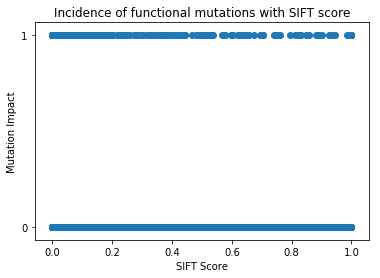

In [3]:
sift_data = impact[~np.isnan(impact.sift_score)]
sift_data = sift_data.loc[:,["sift_score","effect"]]
sift_data['neutral'] = pd.Series(abs(sift_data.effect - 1), index=sift_data.index)

plt.scatter(sift_data.sift_score, sift_data.effect)
plt.yticks([0, 1])
plt.ylabel("Mutation Impact")
plt.xlabel("SIFT Score")
plt.title("Incidence of functional mutations with SIFT score");

We use the effset logistic distribution on the logarithm of the sift score to model the probability:

\begin{equation}
p = \dfrac{1}{1 + e^{\alpha \log{x} + \beta}}
\end{equation}

This gives two parameters to estimate, which can be done using MCMC.

In [ ]:
sift_data2 = sift_data.sample(1000)
sift_data2['sift_log'] = np.log(sift_data2.sift_score)

with pm.Model() as model:
    beta = pm.Normal("beta", mu=0, tau=0.0001, testval=0)
    alpha = pm.Normal("alpha", mu=0, tau=0.0001, testval=0)
    p = pm.Deterministic("p", 1.0/(1. + beta * sift_data2['sift_score'].values ** alpha ))
    
    observed = pm.Bernoulli("bernoulli_obs", p, observed=sift_data2.neutral)
    start = pm.find_MAP()
    #step = pm.Metropolis()
    trace = pm.sample(1000, step=step, start=start, njobs=1)
    burned_trace = trace[500::2]

logp = nan, ||grad|| = 0: 100%|██████████| 42/42 [00:00<00:00, 2172.12it/s]  
/Users/ally/.local/share/virtualenvs/hog-TxCN4_y4/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):


This gives us samples from the posterior of $\alpha$ and $\beta$

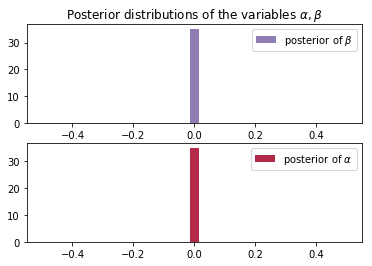

In [9]:
alpha_samples = burned_trace["alpha"][:, None]
beta_samples = burned_trace["beta"][:, None]

#histogram of the samples:
plt.subplot(211)
plt.title(r"Posterior distributions of the variables $\alpha, \beta$")
plt.hist(beta_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\beta$", color="#7A68A6", density=True)
plt.legend()

plt.subplot(212)
plt.hist(alpha_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\alpha$", color="#A60628", density=True)
plt.legend();

In [27]:
s = np.linspace(0, 1, 100)[:, None]
p_s = 1.0 / (1 + np.exp(np.dot(alpha_samples, s.T) + beta_samples))

mean_prob_s = p_s.mean(axis=0)

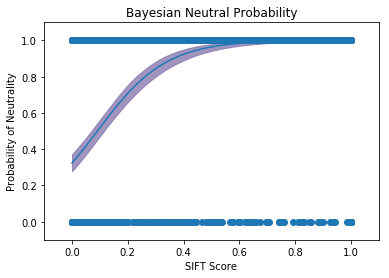

In [29]:
plt.plot(s, mean_prob_s)

from scipy.stats.mstats import mquantiles

qs = mquantiles(p_s, [0.025, 0.975], axis=0)
plt.fill_between(s[:, 0], *qs, alpha=0.7,
                 color="#7A68A6")

plt.scatter(sift_data.sift_score, sift_data.neutral)

plt.ylim(-0.1, 1.1)
plt.xlim(-0.1, 1.1)
plt.ylabel("Probability of Neutrality")
plt.xlabel("SIFT Score")
plt.title("Bayesian Neutral Probability");